# Exploring the critical community size of an SIR model

The critical community size (CCS) refers to the minimum population size required for an infectious disease to persist in a community without going extinct due to random fluctuations.  It would be more accurate to refer to the critical birth cohort, since the key factor is really not the total population but the rate of influx of new susceptibles - however, CCS is the more commonly used term in the field, and we will follow that.  
As shown in [notebook 5](https://github.com/laser-base/laser-generic/blob/f58d3d8a9dfc213551c8a8b5b7c1ef764d5bebbd/notebooks/05_SIR_wbirths_age_distribution.ipynb) on the equilibrium age distribution, the SIR system has an endemic equilibrium solution

$$
(S^*, \: I^*, \: R^*) = N*(\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\
$$

and [notebook 6](https://github.com/laser-base/laser-generic/blob/50796ab5a253df168255e8a3ac54b766f6aa55d5/notebooks/06_SIR_wbirths_natural_periodicity.ipynb), illustrates the stochastic fluctuations in the infectious population around this equilibrium.  It stands to reason, then, the smaller the the equilibrium infected population $\frac{N \mu (R_0-1)}{\beta}$ (or more precisely, the larger the amplitude of fluctuations relative to $ I^* $), the more probable it becomes that the infected population will randomly fluctuate to 0.  In considering spatial patch models of disease transmission, this is a critical behavior that differentiates the disease dynamics of continuous vs. discrete models, and of spatially structured models with many small populations from unstructured models of large populations.  Modeling the spatial population and connectivity structure is thus essential for understanding how local extinctions and reintroductions shape disease persistence at larger scales.

While the intuition makes sense, there's not a single, shared mathematically precise definition of the critical community size - how probable does a stochastic extinction need to be, within how long of a time window, to draw a dividing line between above and below the CCS?  Different authors have taken different approaches to defining CCS and analyzing the system and found slightly different approximations to the CCS.  In Nasell, Theoretical Population Biology 67 (2005) 203–216, we find three formulae (the third credited to Diekmann & Heesterbeek, Mathematical Epidemiology
of Infectious Diseases (2000)):

$$
N_{crit,1} = \frac{2 \pi}{log(2)} \frac{\alpha^\frac{3}{2} R_0}{(R_0-1)^\frac{3}{2}} \\
\\
N_{crit,2} = \frac{K \alpha^2 R_0}{R_0-1} \\ 
\\ 
N_{crit,3} = \frac{\alpha^2 R_0^2}{(R_0-1)^2}\\
$$
where $\alpha = \frac{\gamma + \mu}{\mu}$, and $K$ represents a chosen time horizon in units of $\mu$.  There are slight differences in functional form between these, but what they share in common provides some good intuiation.  First, a strong dependence on the ratio of $\gamma$ to $\mu$ - that is, how long is the infectious period relative to the timescale of susceptible replenishment.  Second, relatively weak dependence on $R_0$ as long as it's reasonably larger than 1.  One might expect $R_0$ to play a large role here, but in fact all diseases seek $R_{eff} \approx 1$ near the endemic equilibrium, and so the impact of $R_0$ on pathogen survival is weak unless $R_0$ is quite small.


In this notebook, we will demonstrate ability to reproduce the CCS phenomenon, and fit CCS against the $\alpha$ & $R_0$ parameters to see which, if any, of the above formula we reproduce.  To do this, we will construct the first patch model in this series of notebooks, setting up each simulation with a set of patches covering a couple orders of magnitude in population size from the smallest to the largest.  As the concept of CCS is defined for a population, we will not yet connect these population patches to each other (that will come in the next notebooks), but will let the disease dynamics play out independently in each to see where the disease persists and where it self-extinguishes.

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet
import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser.generic import SIR
from laser.generic import Model
from laser.generic.newutils import ValuesMap
from laser.generic.vitaldynamics import BirthsByCBR, MortalityByEstimator
from laser.core.utils import grid

import laser.core
import laser.generic

from scipy.optimize import fsolve

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")


np.__version__='2.2.6'
laser.core.__version__='0.7.0'
laser.generic.__version__='0.0.0'


In [2]:
class Importation_EachNode:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 180, count: int = 3, duration: int = 365):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count
        self.duration = duration

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0 and tick < self.duration:
            for node in np.unique(self.model.people.nodeid):
                i_susceptible = np.nonzero(
                    (self.model.people.state == SIR.State.SUSCEPTIBLE.value) &
                    (self.model.people.nodeid == node))[0]
                if len(i_susceptible) > 0:
                    count = min(self.count, len(i_susceptible))
                    i_infect = np.random.choice(i_susceptible, size=count, replace=False)
                    self.model.people.state[i_infect] = SIR.State.INFECTIOUS.value
                    samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                    samples = np.round(samples)
                    samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                    self.model.people.itimer[i_infect] = samples
                    #inf_by_node = np.bincount(self.model.people.nodeid[i_infect], minlength=len(self.model.nodes)).astype(self.model.nodes.S.dtype)
                    self.model.nodes.S[tick + 1, node] -= count
                    self.model.nodes.I[tick + 1, node] += count
                    self.model.nodes.imports[tick, node] = count
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return

In [ ]:
npatches = 31
scenario = grid(M=1, N=31, population_fn=lambda x,y: np.ceil(10**(3 + x*(3/(npatches-1)))), origin_x=0, origin_y=0)
initial_infected = 3

nticks = 50 * 365
nsims = 2
R0_samples = np.random.uniform(3, 16, nsims)
infmean_samples = 5 + np.random.gamma(2, 10, nsims)
cbr_samples = 10 + np.random.gamma(2, 20, nsims)

outputs = np.zeros((nsims, nticks+1, npatches), dtype=np.uint32)
i=0
for R0, infmean, cbr in zip(R0_samples, infmean_samples, cbr_samples):
    print(f"Running simulation {i+1}/{nsims} with R0={R0:.2f}, infmean={infmean:.2f}, cbr={cbr:.2f}")

    scenario["I"] = initial_infected
    scenario["R"] = np.floor(scenario.population * (R0-1)/ R0).astype(np.uint32)
    scenario["S"] = scenario.population - scenario["I"] - scenario["R"]

    parameters = PropertySet(
        {
            "seed": np.random.randint(0, 1000000),
            "nticks": nticks,
            "verbose": True,
            "beta": R0 / infmean,
            "inf_mean": infmean,
            "cbr": cbr,
            "importation_period": 180,
            "importation_count": 3,
            "importation_end": 20 * 365,
        }
    )

    birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)
    infdurdist = dists.exponential(scale=parameters.inf_mean)
    rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
    stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
    pyramid = AliasedDistribution(stable_age_dist)
    survival = KaplanMeierEstimator(stable_age_dist.cumsum())
    model = Model(scenario, parameters, birthrates=birthrate_map)
   
    model.components = [
        SIR.Susceptible(model),
        SIR.Recovered(model),
        SIR.Infectious(model, infdurdist),
        Importation_EachNode(model, infdurdist, period=parameters.importation_period, count=parameters.importation_count, duration=parameters.importation_end),
        SIR.Transmission(model, infdurdist),
        BirthsByCBR(model, birthrates=birthrate_map, pyramid=pyramid),
        MortalityByEstimator(model, estimator=survival),
    ]
    model.run()
    outputs[i, :, :] = model.nodes.I
    os.makedirs("outputs", exist_ok=True)
    np.save(os.path.join("outputs", "CCS_outputs.npy"), outputs)



Running simulation 1/2 with R0=9.15, infmean=18.87, cbr=26.48


31,000 agents in 31 node(s): 100%|██████████| 18250/18250 [00:11<00:00, 1580.95it/s]


Running simulation 1/2 with R0=15.51, infmean=24.69, cbr=23.58


31,000 agents in 31 node(s): 100%|██████████| 18250/18250 [00:11<00:00, 1648.42it/s]


In [4]:
params_df = pd.DataFrame({
    'R0': R0_samples,
    'infmean': infmean_samples,
    'cbr': cbr_samples
})

output_folder = Path('./output')
output_folder.mkdir(exist_ok=True)
params_df.to_csv(output_folder / 'params.csv', index = False)
print(f"Saved parameters to {output_folder / 'params.csv'}")


Saved parameters to output/params.csv


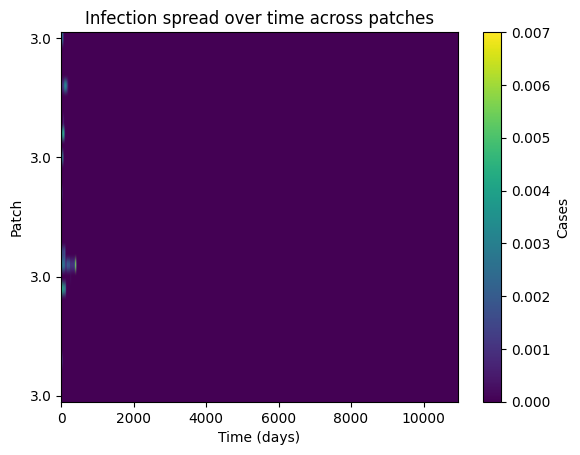

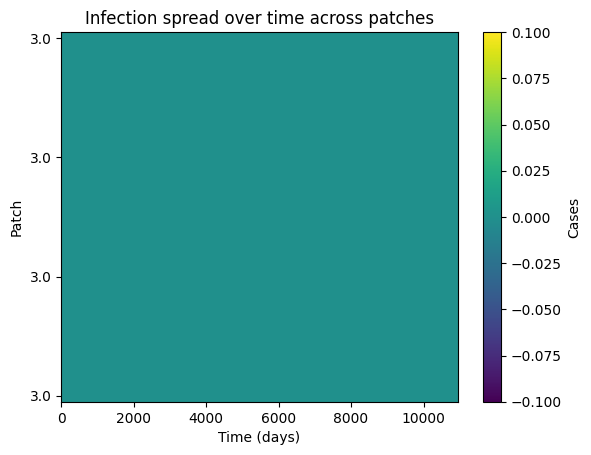

In [5]:
for sim in range(2):
    # plt.imshow(outputs[sim, 7300:, :].T / pops[:, np.newaxis], aspect="auto", origin="lower")
    plt.imshow(outputs[sim, 7300:, :].T / scenario.population.to_numpy()[:, np.newaxis], aspect="auto", origin="lower")
    plt.colorbar(label="Cases")
    plt.xlabel("Time (days)")
    plt.ylabel("Patch")
    plt.yticks(range(0, npatches, 10), np.log10(scenario.population.to_numpy()[::10]))
    plt.title("Infection spread over time across patches")
    plt.show()

In [6]:
output_folder = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "laser-generic-outputs", "CCSSIRoutputs2"))
params_df = pd.read_csv(os.path.join(output_folder, "params.csv"))

outputs = []
nsims = 200
npatches = 61
pops = np.logspace(3, 6, npatches)

for i in range(nsims):
    output_file = os.path.join(output_folder, f"CCSSIRoutputs_{i}.npy")
    outputs.append(np.load(output_file))

outputs = np.array(outputs)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/christopherlorton/projects/laser-generic/docs/laser-generic-outputs/CCSSIRoutputs2/params.csv'

In [ ]:
CCS1 = []
CCS2 = []

for sim in range(nsims):
    end_output = outputs[sim, -1, :]
    zero_pops = pops[end_output == 0]
    nonzero_pops = pops[end_output != 0]

    if len(zero_pops) > 0:
        CCS2.append(np.max(zero_pops))
    else:
        CCS2.append(None)

    if len(nonzero_pops) > 0:
        CCS1.append(np.min(nonzero_pops))
    else:
        CCS1.append(None)

results_df = pd.DataFrame({"largest_zero_pop": CCS2, "smallest_nonzero_pop": CCS1})

print(results_df)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot largest_zero_pop against R0, infmean, and cbr
axs[0, 0].scatter(params_df["R0"], results_df["largest_zero_pop"])
axs[0, 0].set_xlabel("R0")
axs[0, 0].set_ylabel("Largest Zero Pop")
axs[0, 0].set_title("Largest Zero Pop vs R0")
axs[0, 0].set_yscale("log")

axs[1, 0].scatter(params_df["infmean"], results_df["largest_zero_pop"])
axs[1, 0].set_xlabel("Infectious Mean Period")
axs[1, 0].set_ylabel("Largest Zero Pop")
axs[1, 0].set_title("Largest Zero Pop vs Infectious Mean Period")
axs[1, 0].set_yscale("log")

axs[2, 0].scatter(params_df["cbr"], results_df["largest_zero_pop"])
axs[2, 0].set_xlabel("Contact Birth Rate")
axs[2, 0].set_ylabel("Largest Zero Pop")
axs[2, 0].set_title("Largest Zero Pop vs Contact Birth Rate")
axs[2, 0].set_yscale("log")

# Plot smallest_nonzero_pop against R0, infmean, and cbr
axs[0, 1].scatter(params_df["R0"], results_df["smallest_nonzero_pop"])
axs[0, 1].set_xlabel("R0")
axs[0, 1].set_ylabel("Smallest Nonzero Pop")
axs[0, 1].set_title("Smallest Nonzero Pop vs R0")
axs[0, 1].set_yscale("log")

axs[1, 1].scatter(params_df["infmean"], results_df["smallest_nonzero_pop"])
axs[1, 1].set_xlabel("Infectious Mean Period")
axs[1, 1].set_ylabel("Smallest Nonzero Pop")
axs[1, 1].set_title("Smallest Nonzero Pop vs Infectious Mean Period")
axs[1, 1].set_yscale("log")

axs[2, 1].scatter(params_df["cbr"], results_df["smallest_nonzero_pop"])
axs[2, 1].set_xlabel("Contact Birth Rate")
axs[2, 1].set_ylabel("Smallest Nonzero Pop")
axs[2, 1].set_title("Smallest Nonzero Pop vs Contact Birth Rate")
axs[2, 1].set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 7))

# Surface plot for largest_zero_pop
ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_trisurf(params_df["infmean"], params_df["cbr"], results_df["largest_zero_pop"], cmap="viridis")
ax1.set_xlabel("Infectious Mean Period")
ax1.set_ylabel("Contact Birth Rate")
ax1.set_zlabel("Largest Zero Pop")
ax1.set_zscale("log")

ax1.set_title("Largest Zero Pop vs Infectious Mean Period and Contact Birth Rate")

# Surface plot for smallest_nonzero_pop
ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_trisurf(params_df["infmean"], params_df["cbr"], results_df["smallest_nonzero_pop"], cmap="viridis")
ax2.set_xlabel("Infectious Mean Period")
ax2.set_ylabel("Contact Birth Rate")
ax2.set_zlabel("Smallest Nonzero Pop")
ax2.set_title("Smallest Nonzero Pop vs Infectious Mean Period and Contact Birth Rate")
ax2.set_zscale("log")
plt.tight_layout()
plt.show()

In [ ]:
# from scipy.optimize import curve_fit

# # Calculate alpha
# alpha = params_df['infmean'] * params_df['cbr']
# R0 = params_df['R0']

# # Define the fitting function
# def fitting_function(alpha, R0, constant, a, b, c):
#     return constant * alpha**a * (R0)**b * (R0-1)**c

# # Prepare the data for fitting'
# # Drop NA values from smallest_nonzero_pop and corresponding entries from alpha and R0
# valid_indices = ~results_df['smallest_nonzero_pop'].isna()
# alpha_values = alpha[valid_indices].values
# R0_values = params_df['R0'][valid_indices].values
# smallest_nonzero_pop_values = results_df['smallest_nonzero_pop'][valid_indices].values


# # Fit the function to the data
# popt, pcov = curve_fit(lambda alpha, constant, a, b, c: fitting_function(alpha, R0_values, constant, a, b, c), alpha_values, smallest_nonzero_pop_values)

# # Extract the optimal parameters
# constant_opt, a_opt, b_opt, c_opt = popt
print(f"Optimal parameters: constant = {constant_opt}, a = {a_opt}, b = {b_opt}")
# # Plot smallest_nonzero_pop against alpha
# plt.figure()

# # Plot the best fit line
# #
# # Create a meshgrid for alpha and R0 values
# alpha_fit = np.linspace(min(alpha_values), max(alpha_values), 100)
# R0_fit = np.linspace(min(R0_values), max(R0_values), 100)
# alpha_fit, R0_fit = np.meshgrid(alpha_fit, R0_fit)

# # Calculate the best fit surface
# best_fit_surface = fitting_function(alpha_fit, R0_fit, constant_opt, a_opt, b_opt)

# Plot the best fit surface
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection="3d")

# Calculate 1/alpha
inv_alpha_fit = 1 / alpha_fit
inv_alpha_values = 1 / alpha_values

# Plot the best fit surface
ax.plot_surface(inv_alpha_fit, R0_fit, np.log10(best_fit_surface), cmap="viridis", alpha=0.7)

# Scatter the real values for comparison
ax.scatter(inv_alpha_values, R0_values, np.log10(smallest_nonzero_pop_values), color="red", label="Real Values")

ax.set_xlabel("1/Alpha (1/(inf_mean * cbr))")
ax.set_ylabel("R0")
ax.set_zlabel("Log(Smallest Nonzero Pop)")
ax.set_title("Best Fit Surface and Real Values")

# Add the best fit equation as a textbox
equation_text = f"Best fit: y = {constant_opt:.2e} * alpha^{a_opt:.2f} * (R0/(R0-1))^{b_opt:.2f}"
# plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
# Rotate the camera for a better viewing angle
ax.view_init(elev=20, azim=255)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(inv_alpha_values, smallest_nonzero_pop_values)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("1/Alpha (1/(inf_mean * cbr))")
plt.ylabel("Smallest Nonzero Pop")
plt.title("Smallest Nonzero Pop vs 1/Alpha")
plt.grid(True, which="both", ls="--")
plt.show()

In [ ]:
output_folder = "..\..\laser-generic-outputs\CCSSIRoutputs"